# Analyzing Marketing Campaign Data

This Python notebook examines a fictituous marketing campaign dataset originating from an online subscription business. The analysis addresses critical business questions by transforming them into measurable outcomes and encompasses a wide range of marketing metrics, including campaign performance evaluation, subscriber behavior analysis, and an assessment of channel effectiveness with A/B testing. Furthermore, it explores the automation of routine marketing analysis and highlights the significance of data segmentation for enhanced insights.

## Importing and Examining the Data

In [31]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Import dataset
marketing = pd.read_csv('marketing.csv')

# Print the first five rows of the DataFrame
print(marketing.head())

      user_id date_served marketing_channel          variant converted  \
0  a100000029      1/1/18         House Ads  personalization      True   
1  a100000030      1/1/18         House Ads  personalization      True   
2  a100000031      1/1/18         House Ads  personalization      True   
3  a100000032      1/1/18         House Ads  personalization      True   
4  a100000033      1/1/18         House Ads  personalization      True   

  language_displayed language_preferred    age_group date_subscribed  \
0            English            English   0-18 years          1/1/18   
1            English            English  19-24 years          1/1/18   
2            English            English  24-30 years          1/1/18   
3            English            English  30-36 years          1/1/18   
4            English            English  36-45 years          1/1/18   

  date_canceled subscribing_channel is_retained  
0           NaN           House Ads        True  
1           NaN       

In [2]:
# Check column data types and non-missing values
print(marketing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              10037 non-null  object
 1   date_served          10021 non-null  object
 2   marketing_channel    10022 non-null  object
 3   variant              10037 non-null  object
 4   converted            10022 non-null  object
 5   language_displayed   10037 non-null  object
 6   language_preferred   10037 non-null  object
 7   age_group            10037 non-null  object
 8   date_subscribed      1856 non-null   object
 9   date_canceled        577 non-null    object
 10  subscribing_channel  1856 non-null   object
 11  is_retained          1856 non-null   object
dtypes: object(12)
memory usage: 941.1+ KB
None


In [3]:
## Converting data types

# Check the data type of is_retained
print(marketing['is_retained'].dtype)

# Convert is_retained to a boolean
marketing['is_retained'] = marketing['is_retained'].astype('bool')

# Check the data type of is_retained, again
print(marketing['is_retained'].dtype)

object
bool


### Adding New Columns
To derive information from existing data - 
- channel_code: represents the numeric value of the subscribing channel
- is_correct_lang: conveys whether the ad was shown to the user in their preferred language

In [4]:
# Mapping for channels
channel_dict = {"House Ads": 1, "Instagram": 2, "Facebook": 3, "Email": 4, "Push": 5}

# Map the channel to a channel code
marketing['channel_code'] = marketing['subscribing_channel'].map(channel_dict)

# Add the new column is_correct_lang
marketing['is_correct_lang'] = np.where(marketing['language_preferred'] == marketing['language_displayed'],
                            'Yes', 'No')

In [5]:
# Re-import marketing.csv with date columns with correct data types
marketing = pd.read_csv('marketing.csv', parse_dates = ['date_served','date_subscribed', 'date_canceled'])

# Add a Day of Week column
marketing['DoW'] = marketing['date_subscribed'].dt.dayofweek

### Exploring and Visualizing the Marketing Reach
To determine how many users are seeing the marketing assets each day and understand the effectiveness of the  marketing efforts over the past month.

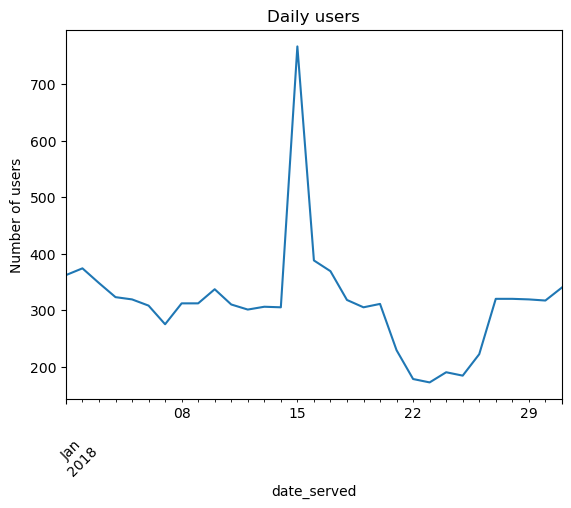

In [6]:
# Group by date_served and count number of unique user_id's
daily_users = marketing.groupby(['date_served'])['user_id'].nunique()

# Plot daily_users
daily_users.plot()
plt.title('Daily users')
plt.ylabel('Number of users')
plt.xticks(rotation = 45)
plt.show()

## Calculating Key Marketing Metrics

### Conversion Rate
The conversion rate is the percentage of users who saw the marketing assets and subsequently became subscribers.
- Number of people who convert / Total number of people marketed to

In [7]:
# Calculate the number of people marketed to
total = marketing['user_id'].nunique()

# Calculate the number of people who subscribed
subscribers = marketing[marketing['converted']==True]['user_id'].nunique()

# Calculate the conversion rate
conversion_rate = subscribers/total

print(round(conversion_rate*100, 2), "%")

13.89 %


### Retention Rate
The number of remaining subscribers from the users who converted to your product. This gives a sense of whether the marketing campaign converted subscribers who were actually interested in the product.
-  Number of people who remain subscribed / Total number of people converted

In [8]:
# Calculate the number of people who remained subscribed
retained = marketing[marketing['is_retained'] == True]['user_id'].nunique()

# Calculate the retention rate
retention_rate = retained/subscribers

print(round(retention_rate*100, 2), "%")

66.8 %


### Automating the Metrics

In [9]:
## Conversion Rate function
def conversion_rate(dataframe, column_names):
    # Total number of converted users
    column_conv = dataframe[dataframe['converted'] == True].groupby(column_names)['user_id'].nunique()

    # Total number users
    column_total = dataframe.groupby(column_names)['user_id'].nunique()   
    
    # Conversion rate 
    conversion_rate = column_conv/column_total
    
    # Fill missing values with 0
    conversion_rate = conversion_rate.fillna(0)
    return conversion_rate

## Retention Rate function
def retention_rate(dataframe, column_names):
    # Total number of retained users who subscribed
    column_retention = dataframe[dataframe['is_retained'] == True].groupby(column_names)['user_id'].nunique()

    # Total number users who subscribed
    column_conv = dataframe[dataframe['converted'] == True].groupby(column_names)['user_id'].nunique()
    
    # Retention rate 
    retention_rate = column_retention/column_conv
    
    # Fill missing values with 0
    retention_rate = retention_rate.fillna(0)
    return retention_rate


### Conversion Rate by Language Segments
Looking at the conversion rate by the language that the marketing asset was shown in helps determine whether the marketing campaign was more effective in certain languages.

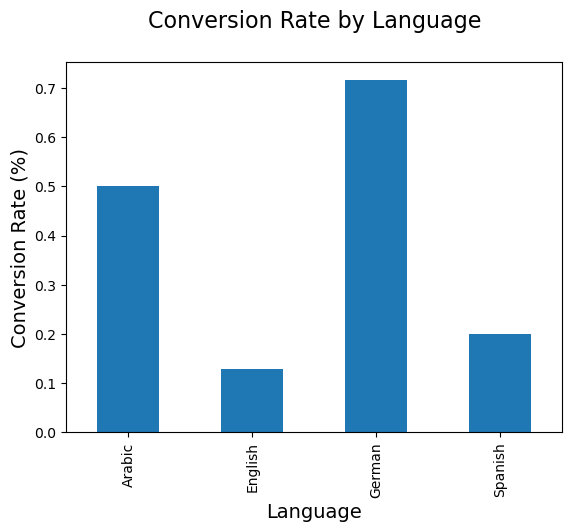

In [10]:
# Calculate the conversion rate for all languages
language_conversion_rate = conversion_rate(marketing, ['language_displayed'])

# Visualize the language_conversion_rate dataframe with a bar plot
language_conversion_rate.plot(kind = 'bar')
plt.title('Conversion Rate by Language\n', size = 16)
plt.ylabel('Conversion Rate (%)', size = 14)
plt.xlabel('Language', size = 14)
plt.show()

### Conversion Rate Over Time
Examining the conversion rate based on when in the month the marketing asset seen by the users. To understand trends over time, looking at the daily conversion rate is crucial to contextualize whether the 
conversion rate on a particular day was good or bad. 

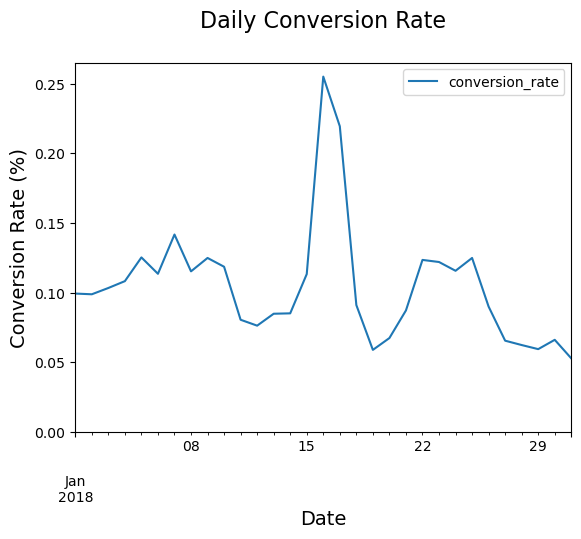

In [11]:
# Calculate the conversion rate per day
daily_conversion_rate = conversion_rate(marketing, ['date_served'])

## Visualize daily conversion rate with a line plot to notice the peaks and valleys in trends over time 

# Reset index to turn the results into a DataFrame
daily_conversion_rate = pd.DataFrame(daily_conversion_rate.reset_index(0))

# Rename columns
daily_conversion_rate.columns = ['date_served', 'conversion_rate']

# Create a line chart using daily_conversion_rate DataFrame
daily_conversion_rate.plot('date_served', 'conversion_rate')
plt.title('Daily Conversion Rate\n', size = 16)
plt.ylabel('Conversion Rate (%)', size = 14)
plt.xlabel('Date', size = 14)
plt.ylim(0)
plt.show()

### Marketing Channels Across Age Groups

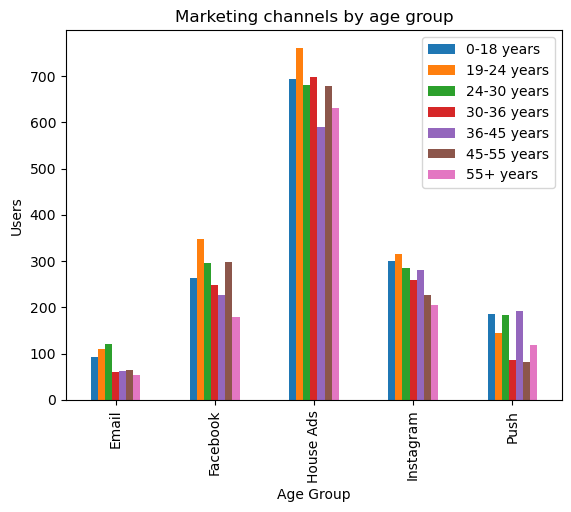

In [12]:
channel_age = marketing.groupby(['marketing_channel', 'age_group'])['user_id'].count()

# Unstack channel_age and transform it into a DataFrame
channel_age_df = pd.DataFrame(channel_age.unstack(level = 1))

# Plot the results
channel_age_df.plot(kind = 'bar')
plt.title('Marketing channels by age group')
plt.xlabel('Age Group')
plt.ylabel('Users')
plt.legend(loc = 'upper right', labels = channel_age_df.columns.values)
plt.show()

### Retention Rates by Subscribing Channels
Identifying each marketing channel's performance is critical as it affects the company strategy going forward. 
If one channel is outperforming others, it might signal the channel merits further investment.

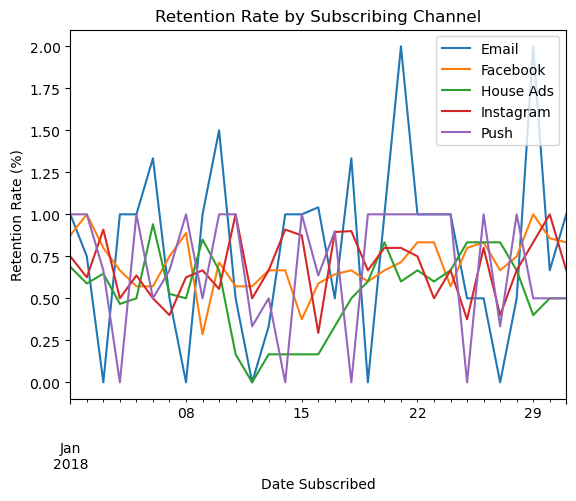

In [13]:
# Calculate the retention rate by channels
retention_rate = retention_rate(marketing, ['date_subscribed', 'subscribing_channel'])

retention_rate_df = pd.DataFrame(retention_rate.unstack(level=1))

## Visualize

# Plot retention rate
retention_rate_df.plot()
plt.title('Retention Rate by Subscribing Channel')
plt.xlabel('Date Subscribed')
plt.ylabel('Retention Rate (%)')
plt.legend(loc = 'upper right', labels = retention_rate_df.columns.values)
plt.show()

### Automating Conversion Rate Visuals

In [14]:
def plotting_conv(dataframe):
    for column in dataframe:
        # Plot column by dataframe's index
        plt.plot(dataframe.index, dataframe[column])
        plt.title('Daily ' + str(column) + ' conversion rate\n', size = 16)
        plt.ylabel('Conversion rate', size = 14)
        plt.xlabel('Date', size = 14)
        # Show plot
        plt.show()
        plt.clf()

### Conversion Rate by Age Groups

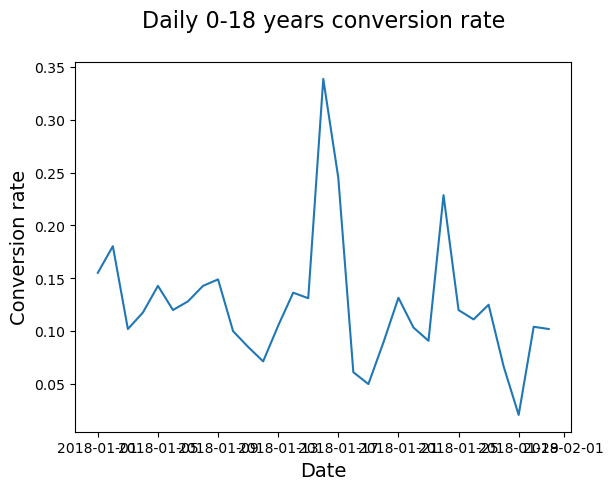

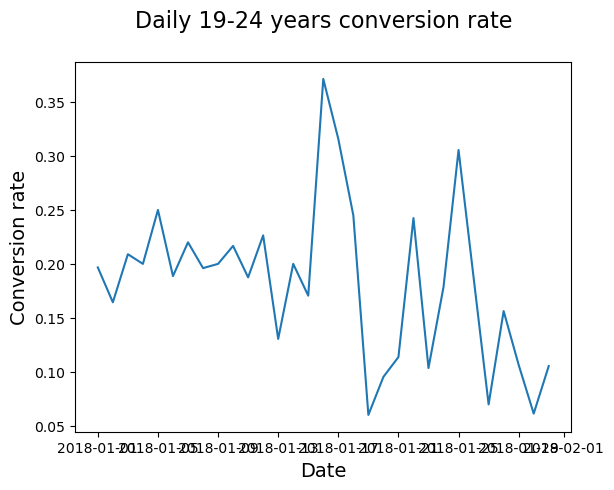

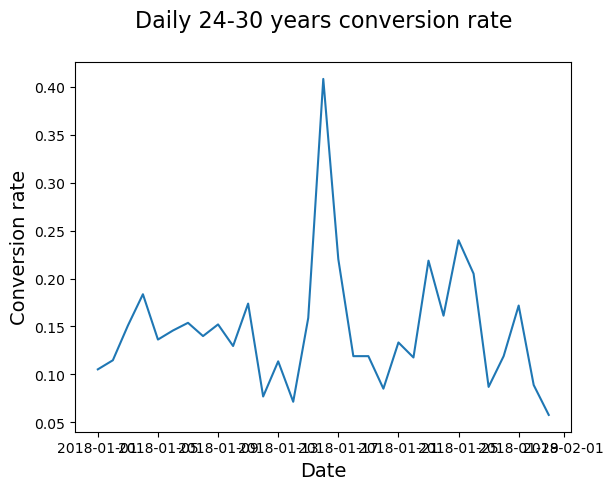

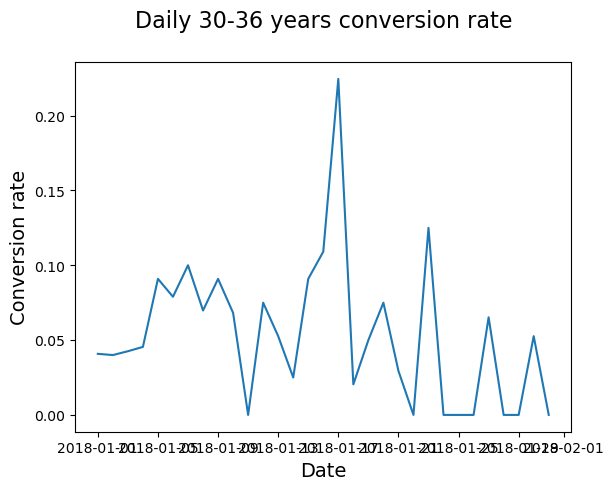

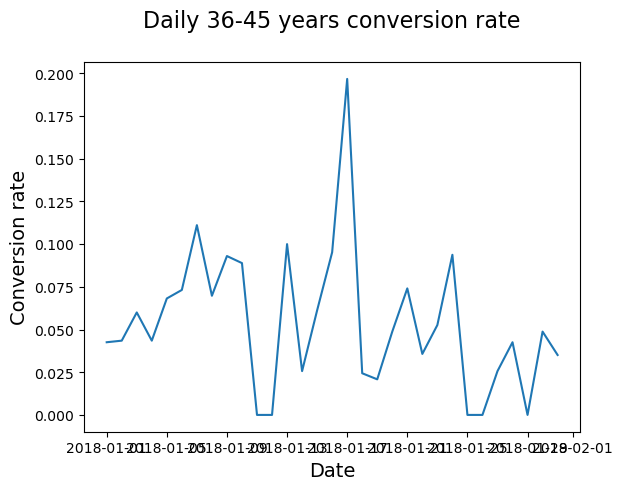

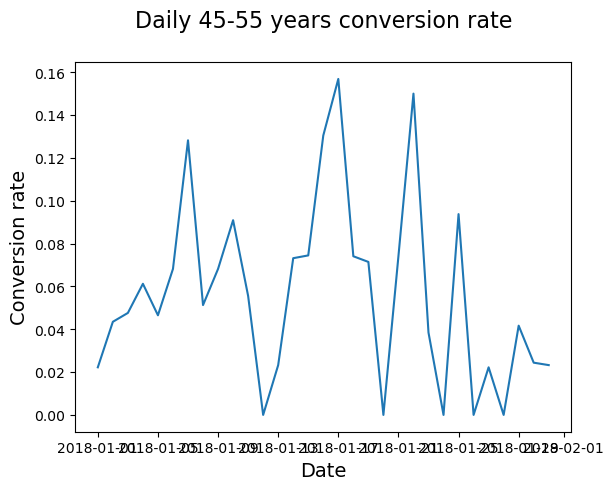

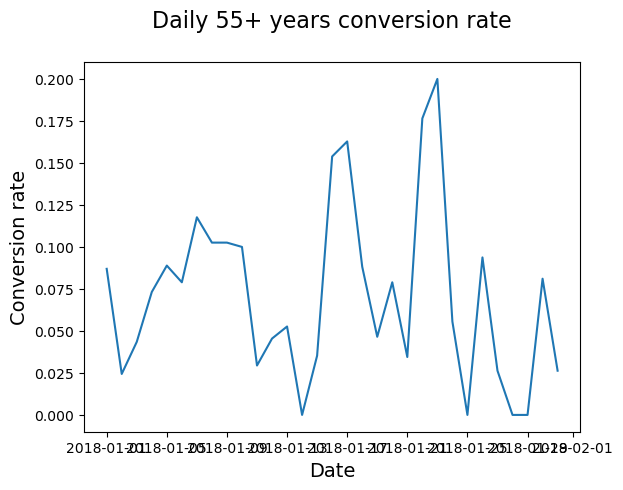

<Figure size 640x480 with 0 Axes>

In [15]:
# Calculate conversion rate by date served and age group
age_group_conv = conversion_rate(marketing, ['date_served', 'age_group'])

# Unstack age_group_conv and create a DataFrame
age_group_df = pd.DataFrame(age_group_conv.unstack(level=1))

# Plot the results
plotting_conv(age_group_df)

### Conversion Rate by Marketing Channels

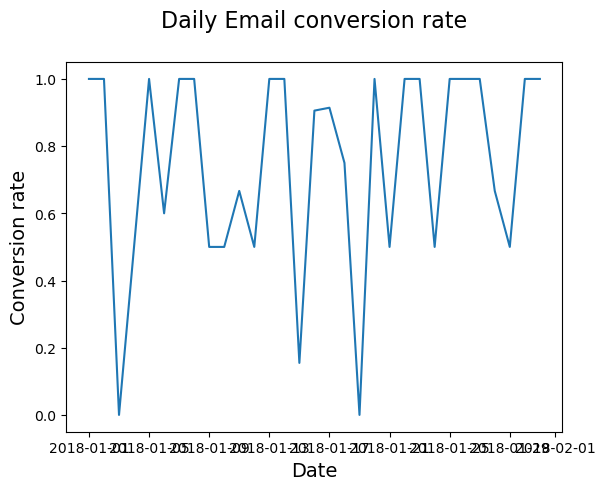

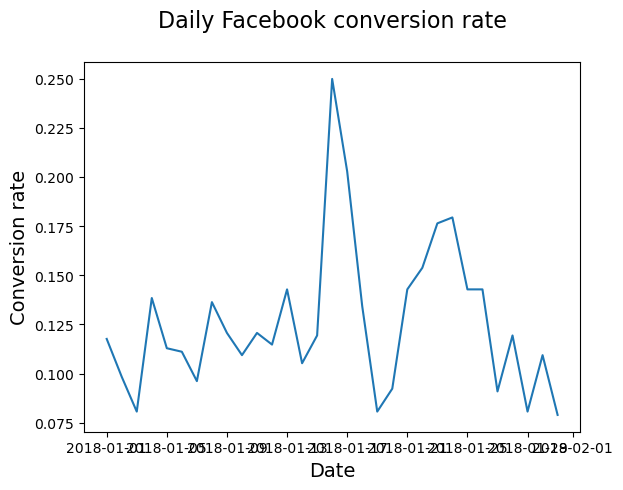

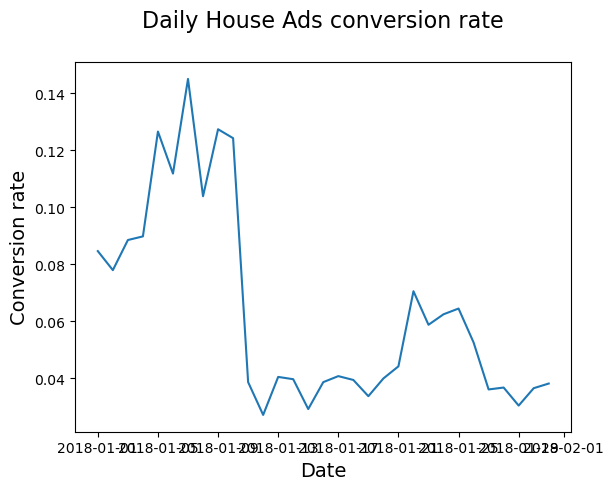

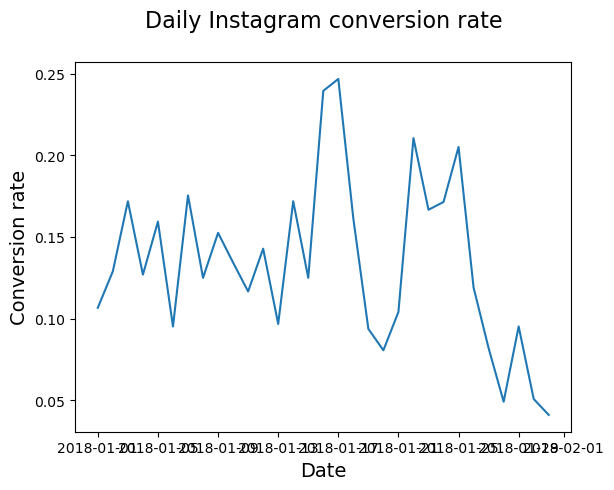

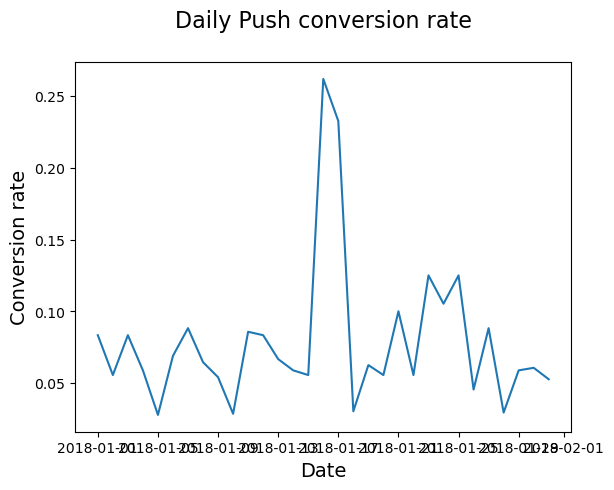

<Figure size 640x480 with 0 Axes>

In [16]:
# Calculate conversion rate by date served and channel
daily_conv_channel = conversion_rate(marketing, ['date_served', 'marketing_channel'])

# Unstack daily_conv_channel and convert it to a DataFrame
daily_conv_channel = pd.DataFrame(daily_conv_channel.unstack(level = 1))

# Plot results of daily_conv_channel
plotting_conv(daily_conv_channel)

## Analyzing Conversion Rate Irregularities within the House Ads Channel

The potential causes for the decrease in the house ads conversion since January 11 could be due to 
expected shifts in user behavior or a larger problem in technical implementation or marketing strategy. 

#### 1. Start by checking whether users are more likely to convert on weekends compared with weekdays.

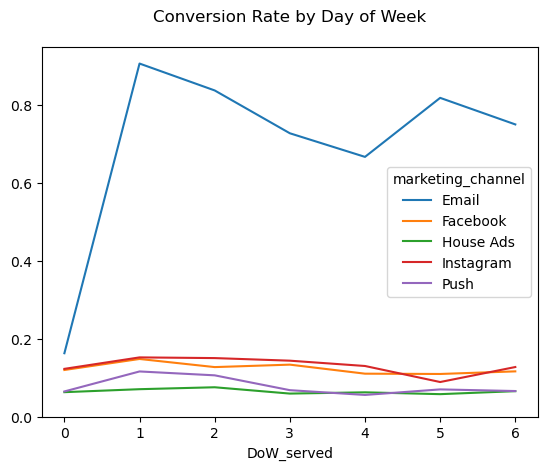

In [17]:
# Add day of week column to marketing
marketing['DoW_served'] = marketing['date_served'].dt.dayofweek

# Calculate conversion rate by day of week
DoW_conversion = conversion_rate(marketing, ['DoW_served', 'marketing_channel'])

# Unstack channels
DoW_df = pd.DataFrame(DoW_conversion.unstack(level=1))

# Plot conversion rate by day of week
DoW_df.plot()
plt.title('Conversion Rate by Day of Week\n')
plt.ylim(0)
plt.show()

#### 2. Since natural fluctuations across the day of the week a user saw the marketing assets can be ruled out based on the above graph, next, look at conversion by language over time to see if the marketing campaign applies broadly across different cultures.

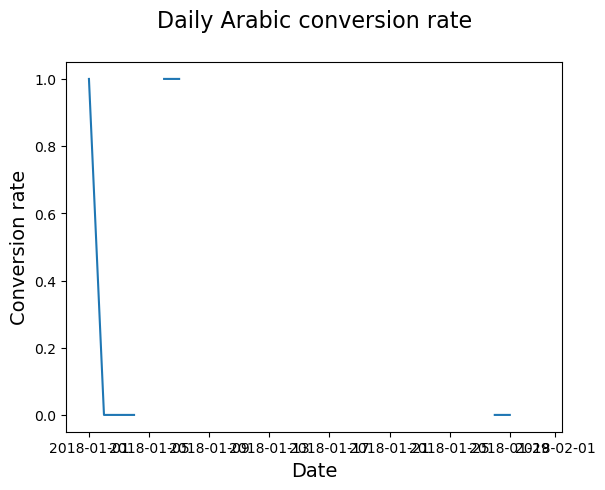

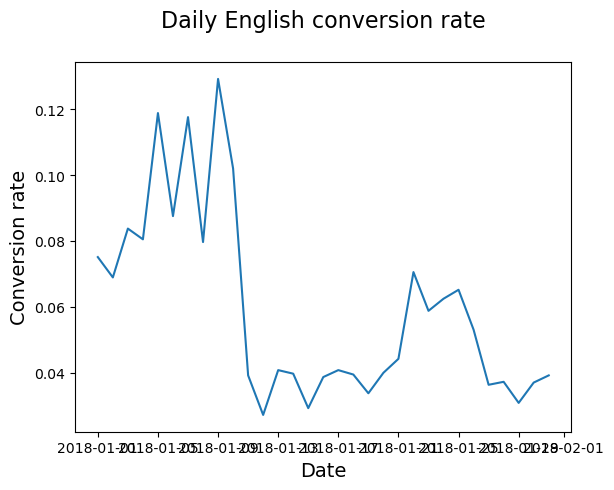

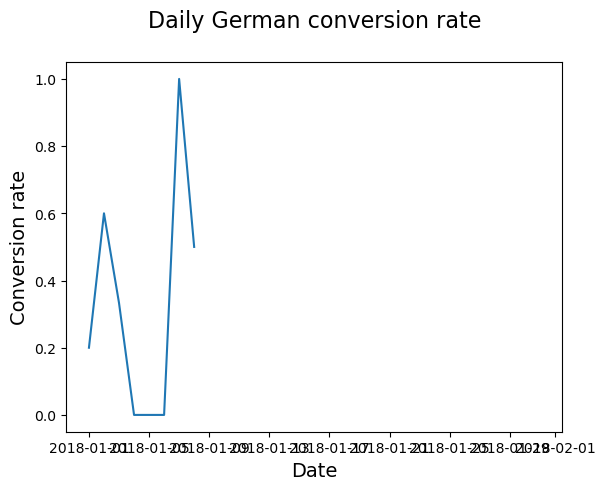

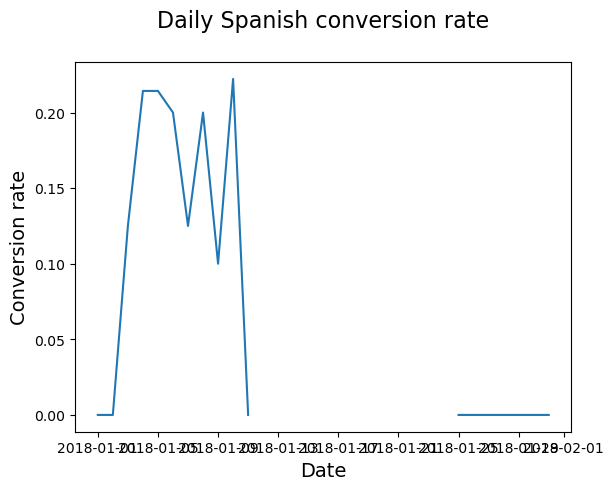

<Figure size 640x480 with 0 Axes>

In [18]:
# Isolate the rows where marketing channel is House Ads
house_ads = marketing[marketing['marketing_channel'] == 'House Ads']

# Calculate conversion by date served and language displayed
conv_lang_channel = conversion_rate(house_ads, ['date_served', 'language_displayed'])

# Unstack conv_lang_channel
conv_lang_df = pd.DataFrame(conv_lang_channel.unstack(level=1))

# Use plotting function to display results
plotting_conv(conv_lang_df)

#### 3. A pattern around language preferences can be noticed based on the above graphs. Using this information, identifying what percentage of users were not being served ads in the right language would be the next step.

/var/folders/vf/hb6cjwg57s92wl_f0zy8x8jw0000gn/T/ipykernel_42196/1199877814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_ads['is_correct_lang'] = np.where(house_ads['language_preferred'] == house_ads['language_displayed'],


is_correct_lang    No    Yes
date_served                 
2018-01-01        2.0  189.0
2018-01-02        3.0  247.0
2018-01-03        0.0  220.0
2018-01-04        0.0  168.0
2018-01-05        0.0  160.0
2018-01-06        1.0  151.0
2018-01-07        2.0  130.0
2018-01-08        0.0  154.0
2018-01-09        0.0  157.0
2018-01-10        0.0  170.0
2018-01-11       20.0  135.0
2018-01-12       18.0  130.0
2018-01-13       26.0  122.0
2018-01-14       20.0  131.0
2018-01-15       16.0  192.0
2018-01-16       28.0  127.0
2018-01-17       21.0  127.0
2018-01-18       31.0  121.0
2018-01-19       22.0  127.0
2018-01-20       28.0  124.0
2018-01-21       14.0  100.0
2018-01-22       13.0   72.0
2018-01-23       16.0   69.0
2018-01-24       13.0   83.0
2018-01-25       19.0   74.0
2018-01-26       24.0   92.0
2018-01-27       18.0  149.0
2018-01-28       28.0  136.0
2018-01-29       24.0  142.0
2018-01-30       23.0  145.0
2018-01-31       23.0  135.0


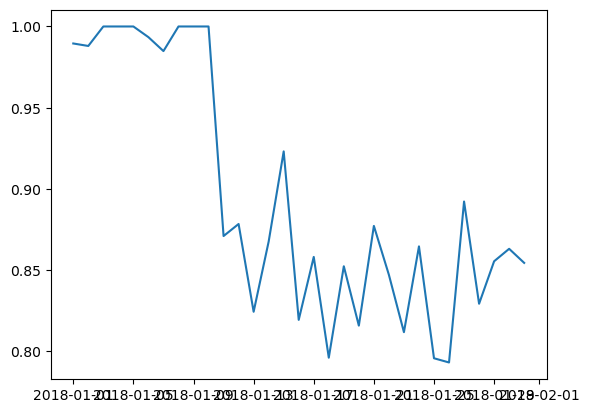

In [19]:
# Add the new column is_correct_lang
house_ads['is_correct_lang'] = np.where(house_ads['language_preferred'] == house_ads['language_displayed'],
                                'Yes','No')

# Groupby date_served and is_correct_lang
language_check = house_ads.groupby(['date_served','is_correct_lang'])['is_correct_lang'].count()

# Unstack language_check and fill missing values with 0's
language_check_df = pd.DataFrame(language_check.unstack(level=1)).fillna(0)

# Print results
print(language_check_df)

# Divide the count where language is correct by the row sum
language_check_df['pct'] = language_check_df['Yes']/language_check_df.sum(axis=1)

# Plot
plt.plot(language_check_df.index.values, language_check_df['pct'])
plt.show()

#### 4. Due to the error within the House Ads conversion, how many subscribers were lost as a result of this bug?

In [20]:
# Calculate pre-error conversion rate
house_ads_bug = house_ads[house_ads['date_served'] < '2018-01-11']
lang_conv = conversion_rate(house_ads_bug, ['language_displayed']) 

# Index other language conversion rates against English
spanish_index = lang_conv['Spanish']/lang_conv['English']
arabic_index = lang_conv['Arabic']/lang_conv['English']
german_index = lang_conv['German']/lang_conv['English']

print("Spanish index:", spanish_index)
print("Arabic index:", arabic_index)
print("German index:", german_index)

Spanish index: 1.681924882629108
Arabic index: 5.045774647887324
German index: 4.485133020344287


#### 5. To understand the true impact of the bug and the scale of the problem to prevent this kind of error in the future, it is crucial to determine how many subscribers would have been expected had there been no error. 

In [21]:
# Group house_ads by date and language
converted = house_ads.groupby(['date_served', 'language_preferred']).agg({'user_id':'nunique','converted':'sum'})
converted = pd.DataFrame(converted.unstack(level=1))

## Build out a DataFrame that will estimate what daily conversion rates should have been if users were being 
# served the correct language.

# Create English conversion rate column for affected period
converted['english_conv_rate'] = converted.loc['2018-01-11':'2018-01-31'][('converted','English')]

# Create expected conversion rates for each language
converted['expected_spanish_rate'] = converted['english_conv_rate']*spanish_index
converted['expected_arabic_rate'] = converted['english_conv_rate']*arabic_index
converted['expected_german_rate'] = converted['english_conv_rate']*german_index

# Multiply number of users by the expected conversion rate
converted['expected_spanish_conv'] = converted['expected_spanish_rate']/100*converted[('user_id','Spanish')]
converted['expected_arabic_conv'] = converted['expected_arabic_rate']/100*converted[('user_id','Arabic')]
converted['expected_german_conv'] = converted['expected_german_rate']/100*converted[('user_id','German')]

#### 6. Calculating the number of subscribers that were lost due to mistakenly not serving users in their preferred language. 

In [22]:
# Use .loc to slice only the relevant dates
converted = converted.loc['2018-01-11':'2018-01-31']

# Sum expected subscribers for each language
expected_subs = converted['expected_spanish_conv'].sum() + converted['expected_arabic_conv'].sum() + \
                converted['expected_german_conv'].sum()

# Calculate how many subscribers we actually got
actual_subs = converted[('converted','Spanish')].sum() + converted[('converted','Arabic')].sum() + \
                converted[('converted','German')].sum()

# Subtract how many subscribers we got despite the bug
lost_subs = expected_subs - actual_subs

print(lost_subs)

32.144143192488265


## A/B Testing - Email Marketing Channel

The email portion of this campaign was actually run as an A/B test where half the emails sent out were based on generic upsells while the other half contained personalized messaging around the users’ usage of the site.

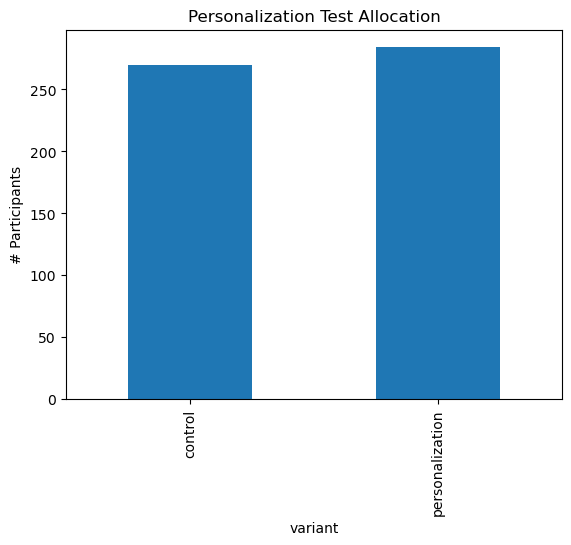

In [23]:
# Ensure users were allocated equally to the test and control groups

# Subset the DataFrame
email = marketing[marketing['marketing_channel'] == 'Email']

# Group the email DataFrame by variant 
alloc = email.groupby(['variant'])['user_id'].nunique()

# Plot a bar chart of the test allocation
alloc.plot(kind='bar')
plt.title('Personalization Test Allocation')
plt.ylabel('# Participants')
plt.show()

### Conversion Rates between the Control and Personalization 
Measuring and comparing these rates aids in evaluating the success of the A/B test.

In [24]:
# Group marketing by user_id and variant
subscribers = email.groupby(['user_id', 'variant'])['converted'].max()
subscribers_df = pd.DataFrame(subscribers.unstack(level=1)) 

# Drop missing values from the control and personalization columns
control = subscribers_df['control'].dropna()
personalization = subscribers_df['personalization'].dropna()

print('Control conversion rate:', np.mean(control))
print('Personalization conversion rate:', np.mean(personalization))

Control conversion rate: 0.2814814814814815
Personalization conversion rate: 0.3908450704225352


### Calculating the Lift and t-stat
Lift indicates the relative improvement or change in a key performance metric between the control group and the personalization group. 
- Lift = (Treatment Conversion Rate - Control Conversion Rate)/Control Conversion Rate

T-stat is a measure that evaluates the statistical significance of differences between two groups and quantifies how much the observed difference exceeds the data's inherent variability. 
- A higher t-statistic indicates a more significant difference, making it less likely to be random.

In [58]:
# Ensure that the data in control and personalization is numeric
control = control.astype(float)  
personalization = personalization.astype(float)
        
## Lift function
def lift(a,b):
    # Calcuate the mean of a and b 
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    
    # Calculate the lift using a_mean and b_mean
    lift = (b_mean-a_mean)/a_mean
  
    return str(round(lift*100, 2)) + '%'
  
# Print lift() with control and personalization as inputs
print('Lift: ', lift(control, personalization))

## t-stat function
def ttest(control, personalization):
    t_stat = stats.ttest_ind(control, personalization)
    return t_stat

# Print tstat with control and personalization as inputs
print('t-test: ', ttest(control, personalization))

Lift:  38.85%
t-test:  Ttest_indResult(statistic=-2.734329944750507, pvalue=0.006451487844694182)


##### Result Interpretation: Personalization outperformed the control group, as indicated by a positive Lift of approximately 38.85% and a statistically significant difference with a t-statistic of approximately -2.73 and a low p-value of approximately 0.00645.

### A/B testing on Segments
Sometimes features that are highly appealing to one group are less appealing to others. Analyzing the impact of 
A/B tests on segments of data can provide further valuable insights into enhancing future strategies.

In [60]:
def ab_segmentation(segment):
  # Build a for loop for each segment in marketing
  for subsegment in np.unique(marketing[segment].values):
      print(subsegment)
      
      # Limit marketing to email and subsegment      
      email = marketing[(marketing['marketing_channel'] == 'Email') & (marketing[segment] == subsegment)]

      subscribers = email.groupby(['user_id', 'variant'])['converted'].max()
      subscribers = pd.DataFrame(subscribers.unstack(level=1)) 
        
      control = subscribers['control'].dropna().astype(float)
      personalization = subscribers['personalization'].dropna().astype(float)

      # Calculate lift and t-statistic
      lift_result = lift(control, personalization)
      tstat_result = ttest(control, personalization)

      # Print only the lift and t-statistic
      print('lift:', lift_result)
      print('t-statistic:', tstat_result[0], '\n')  # Access the t-statistic from the result tuple

In [61]:
# Use ab_segmentation on age group
ab_segmentation('age_group')

0-18 years
lift: 121.4%
t-statistic: -2.966044912142212 

19-24 years
lift: 106.24%
t-statistic: -3.0317943847866697 

24-30 years
lift: 161.19%
t-statistic: -3.861539544326876 

30-36 years
lift: -100.0%
t-statistic: 3.185906464414798 

36-45 years
lift: -85.23%
t-statistic: 2.431790127931851 

45-55 years
lift: -72.22%
t-statistic: 2.0654991273179326 

55+ years
lift: -100.0%
t-statistic: 3.326565456420339 



##### Result Interpretation: Personalization is effective and statistically significant in age groups 0-24, leading to performance improvements. In age groups 30-45 and 55+, personalization results in statistically significant performance declines, indicating its ineffectiveness for these groups.

### This analysis has revealed valuable insights using the specific segments within the data which enables the tailoring of campaign strategies to better align with the unique needs of target audiences, ultimately enhancing the effectiveness of marketing efforts.